In [1]:
import torch
import numpy as np
from scipy.spatial import distance
import os 
from PIL import Image
import torchvision.transforms as transforms
import torch
from train_contrastive import SiameseNetwork
from torch.autograd import Variable
import requests
import io
%matplotlib inline


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/data/omran/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/data/omran/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/data/omran/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.13.1-unknown is an invalid version and will not be supported in a future release
  warnings.warn(


In [9]:
# take one image embedding, one class and return if votes 

def socre_one_image(img_embedding,databse_embeddings,vote_thr=0.1):
        
    sum_distance = 0
    vote         = 0
    len_class = len(databse_embeddings)   
       
    for one_image in databse_embeddings:
        
        
        dist_cosine = distance.cosine(one_image, img_embedding)
        sum_distance += dist_cosine
            
        if(dist_cosine< vote_thr):
            vote+=1
        
         
        dist_avge = (sum_distance/len_class)    
        
        
        
    return vote,len_class,dist_avge

In [24]:
# get one image embeddings 

# two images urls 

def get_image_embeddings(im_path,url=False):
    

    
    if(url):
        response = requests.get(im_path).content
        im_1 = Image.open(io.BytesIO(response)) 
    else:
        im_1 = Image.open(im_path) 


    if im_1.mode != "RGB":
        im_1 = im_1.convert("RGB")

    
    transform=transforms.Compose([transforms.Resize(224),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  ]
                                )

    im_1_T = transform(im_1)

    display(transforms.ToPILImage()(im_1_T))

    im_1_T =im_1_T[None, :]
    

    model_path  = '/data/omran/cities_data/models/resnet101_64_embedding/220912-0923/ckpts/epoch_34.ckpt'
    model = SiameseNetwork.load_from_checkpoint(model_path).cuda()
    model.eval()

    output1, _ = model(Variable(im_1_T).cuda(),Variable(im_1_T).cuda())

    return output1[0].cpu().detach().numpy() 

In [75]:
# Class_embeddings 

databse_embeddings = np.load('/data/omran/cities_data/embeddings/test/New_york_4.npy')

# Input images 

#in_im = get_image_embeddings('/data/omran/cities_data/dataset/cities/test_10_images_ready/London/Ae0IWyHBuB0.jpeg')
#in_im = get_image_embeddings('https://graylinenewyork.com/files/3415/4521/8478/new-york-city-hudson-river.jpg')
input_image_class  = np.load('/data/omran/cities_data/embeddings/test/New_york_4.npy')

in_im = input_image_class[0]

class_vote,len_class,class_sum = socre_one_image(in_im, databse_embeddings, vote_thr=0.1)
    
    
#print(f'class_vote : {class_vote} out of {len_class} and class_sum : {class_sum}')
#print('#######################################################')

#if (class_vote >= 10 or class_sum < 0.6):
#    print('YES')
#else:
#    print('NO')

count = 0 

for i in range(len_class):
    class_vote,len_class,class_sum = socre_one_image(input_image_class[i], databse_embeddings, vote_thr=0.1)
    if (class_vote >= 10 or class_sum < 0.6):  # class_vote >= 10 or
        count+=1

        
print(count)
#class_vote,len_class,class_sum = socre_one_image(input_image_class[9], databse_embeddings, vote_thr=0.25)
    
    
#print(f'class_vote : {class_vote} out of {len_class} and class_sum : {class_sum}')


74


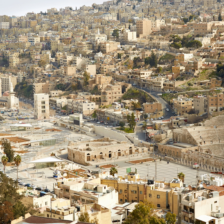

class_vote : 8 out of 500 and class_sum : 1.0540208723638789
#######################################################
NO


In [12]:
# Open Set 

# Class_embeddings 

databse_embeddings = np.load('/data/omran/cities_data/embeddings/open_set/New_york_4.npy')

# Input images 

#in_im = get_image_embeddings('/data/omran/cities_data/dataset/cities/test_10_images_ready/London/Ae0IWyHBuB0.jpeg')
in_im = get_image_embeddings('https://i.natgeofe.com/n/4fb1ca51-63cc-4d5d-9ee3-a4a413c0b7c7/cityscape-amman-jordan_3x4.jpg')
#input_image_class  = np.load('/data/omran/cities_data/embeddings/open_set/Paris_3.npy')

#in_im = input_image_class[4]

class_vote,len_class,class_sum = socre_one_image(in_im, databse_embeddings, vote_thr=0.25)
    
    
print(f'class_vote : {class_vote} out of {len_class} and class_sum : {class_sum}')
print('#######################################################')

if (class_vote >= len_class/2 and class_sum < 0.5):
    print('YES')
else:
    print('NO')

#class_vote,len_class,class_sum = socre_one_image(input_image_class[9], databse_embeddings, vote_thr=0.25)
    
    
#print(f'class_vote : {class_vote} out of {len_class} and class_sum : {class_sum}')


In [76]:
# Negative class 

# Class_embeddings 

postive_class = np.load('/data/omran/cities_data/embeddings/test/New_york_4.npy')

# Input images 

databse_embeddings    = '/data/omran/cities_data/embeddings/test'

negatvie_embeddings   = np.load('/data/omran/cities_data/embeddings/test/Cairo_0.npy')
 

for filename in os.listdir(databse_embeddings):
    class_name = filename[:-6]
    test_file = os.path.join(databse_embeddings, filename)
    
    input_image_class = np.load(test_file)
    
    #print(class_name)
    
    if(class_name == 'Moscow' or class_name == 'Cairo' ):
        #print(class_name)
        continue
    
    input_image_class = np.load(test_file) 
    
    negatvie_embeddings = np.concatenate((negatvie_embeddings, input_image_class), axis=0)

np.random.shuffle(negatvie_embeddings)
negatvie_embeddings_sample = (negatvie_embeddings)[:200]

print((negatvie_embeddings_sample.size)) 

count = 0 

len_class = len(postive_class)


for i in range(len(postive_class)):
 
    class_vote,len_class,class_sum = socre_one_image(postive_class[i], negatvie_embeddings_sample, vote_thr=0.1)
    

    if ( class_vote >= 10 or class_sum < 0.6):   # class_vote >= 10 or
        count+=1

        
print(f'count {count} out of {len_class} , {count/len_class}')

12800
count 29 out of 200 , 0.145
